# 探索性資料分析

探索性資料分析是指利用描述統計和圖形表示等方式對資料進行初步調查，目的是發現模式(patterns)，偵測異常(anomalies)以及檢驗假設(assumptions)。

目前並沒有十分嚴格的探索性資料分析流程。但大部分的資料可以依據以下的步驟進行：

1. 發現資料中每個Variable的型態與意義。找出或轉換了解問題所需的資料Variables。

2. 資料中是否有錯誤，例如資料重複或輸入錯誤？發生在那些Variable上？如何處理這些錯誤？

3. 資料中是否有遺漏值 (missing values)，發生在那些Variable上？如何處理這些遺漏值？

4. 根據資料的分布範圍，哪些是與其他資料大不相同的異常值(outliers)？這些異常值要如何處理？

5. 原始資料是否需要彙整？換句說，將以一筆資料**代表**一群相關的Observations。如何代表？

6. Variables有無需要進行合併？如何進行合併？

7. 形成問題的假設，從資料中發展出想要了解的問題。

8. 有必要的話，重複上面的各個步驟。

## 載入套件與讀取資料

### 載入套件

In [1]:
# 載入所需套件

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

### 讀取資料集

此次分析的資料集是[線上零售資料集](https://archive.ics.uci.edu/ml/datasets/Online+Retail)。
這個檔案是excel格式，可以利用pandas的read_excel讀取成為資料框(data frame)。

In [2]:
# 讀入資料檔
df = pd.read_excel('Online Retail.xlsx')

### 查看資料集的資訊

- 讀取的資料大小

In [ ]:
df.shape

541909列(rows，紀錄)，8行(columns，欄位)

- 資料的欄位名稱

In [ ]:
df.info()

這是一個交易發票的檔案，包含發票編號(InvoiceNo)、貨品編號(StockCode)、描述(Description)、數量(Quantity)、發票日期(InvoiceDate)、單價(UnitPrice)、顧客識別號(CustomerID)、國別(Country)等變數欄位。
其中，Quantity是整數資料型態，UnitPrice和CustomerID是浮點數，InvoiceDate是日期時間資料型態，其餘皆為文字。

- 數值類型的欄位資料的統計描述情形

In [ ]:
df.describe()

- 日期時間資料的最大與最小值

In [ ]:
print('最後日期', df.InvoiceDate.max(), '最前日期', df.InvoiceDate.min())


發票紀錄的時間超過1年

### 資料的內容

前五筆資料

In [ ]:
df.head()

後五筆資料

In [ ]:
df.tail()

## 處理資料集內遺失、多餘以及可疑的資料

### 遺失資料處理

從df.info()的結果可以發現CustomerID缺乏相當多資料。
因此，首先列出CustomerID沒有資料的紀錄觀察。

In [ ]:
df[df.CustomerID.isnull()]

去除CustomerID沒有資料的紀錄

In [3]:
df = df.dropna(subset=['CustomerID'])

確認是否去除成功

In [ ]:
df[df.CustomerID.isnull()]

### 多餘資料處理

如前面的分析結果，發票日期在2010-12-01到2011-12-09間，稍微超過一年。
為了方便計算起見，取2010-12-09到2011-12-09之間的資料。

為了處理時間資料，載入datetime套件

In [4]:
from datetime import date

In [8]:
df = df.assign(PurchaseDate=df.InvoiceDate.apply(lambda x: x.date()))

In [9]:
df = df[df.PurchaseDate>=date(2010, 12, 9)]

In [11]:
df = df.assign(PurchaseHour=df.InvoiceDate.dt.hour)

### 特殊資料處理

查看數量(Quantity)為負或0的情形


In [ ]:
df[df.Quantity<=0]

當Quantity<=0時，該筆交易為取消，InvoiceNo的首字為C

In [12]:
#取出購買紀錄(不包含取消紀錄)
df_purchase = df[df.Quantity>0] 
# 計算該筆紀錄的購買總價
df_purchase = df_purchase.assign(Total = df_purchase.UnitPrice*df_purchase.Quantity)

查看單價(UnitPrice)為負或0的情形

In [ ]:
df_purchase[df_purchase.UnitPrice<=0]

## 資料群組彙整分析

### 統計各國的購買交易數(不同的發票號碼)與顧客數(不同的顧客識別號)

In [13]:
'''
以國家分組： groupby('Country')
依據發票編號，計算不重複的次數： "InvoiceNo":"nunique"
依據顧客編號，計算不重複的次數： "CustomerID":"nunique"
根據發票編號數量，由大到小排列： sort_values("InvoiceNo", ascending=False)
'''
df_purchase.groupby('Country').agg({"InvoiceNo":"nunique", "CustomerID":"nunique"}).reset_index()\
.sort_values("InvoiceNo", ascending=False)

,Country,InvoiceNo,CustomerID
34,United Kingdom,16017,3863
14,Germany,445,93
13,France,382,85
10,EIRE,252,3
3,Belgium,97,25
22,Netherlands,94,8
29,Spain,89,30
0,Australia,55,9
25,Portugal,54,19
31,Switzerland,50,21


以英國(United Kingdom)為此線上商店的主要銷售國家，其餘的重要國家也大都在歐洲

### 查看顧客的購買次數與金額

查看顧客的購買次數與金額(附註：此為RFM模式中的購買頻率'Frequency'和購買金額'Monetary')

In [14]:
# 顧客的購買次數與金額(每一次購買紀錄為同一個發票編號)
'''
以顧客編號分組： groupby('CustomerID')
依據發票編號，計算不重複的次數： "InvoiceNo": "nunique"
計算所有發票每項貨品總價的總和： "Total": "sum"
根據發票編號數量，由大到小排列： sort_values("InvoiceNo", ascending=False)
'''
pur_customer = df_purchase.groupby('CustomerID')\
.agg({"InvoiceNo": "nunique", "Total": "sum"}).reset_index() \
.sort_values('InvoiceNo', ascending=False)

pur_customer

,CustomerID,InvoiceNo,Total
322,12748.0,196,31854.58
1859,14911.0,194,140359.03
3960,17841.0,121,39707.96
554,13089.0,94,55595.21
1644,14606.0,90,11549.77
...,...,...,...
2812,16222.0,1,846.72
2808,16216.0,1,914.93
2807,16215.0,1,242.35
1019,13737.0,1,339.60


### 將顧客的購買次數與金額繪成圖形

In [15]:
'''
圖形中有中文字型的問題
參考
https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/359974/
'''
from matplotlib.font_manager import FontProperties

han_font = FontProperties(fname=r"c:/windows/fonts/msjh.ttc", size=14) # 中文字形

In [16]:
'''
設計圖形呈現的外觀風格
'''
sns.set(style="whitegrid")

以散佈圖繪製顧客的購買次數與金額

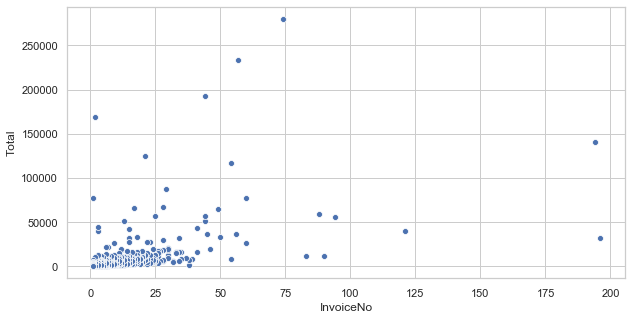

In [17]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=pur_customer, x='InvoiceNo',y='Total')

Text(0.5, 1.0, '顧客的購買次數與金額')

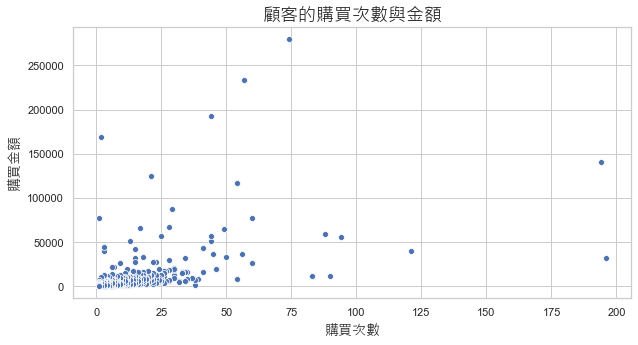

In [18]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=pur_customer, x='InvoiceNo',y='Total')
# 加上圖形上的標題
ax.set_xlabel('購買次數', fontproperties=han_font)
ax.set_ylabel('購買金額', fontproperties=han_font)
ax.set_title('顧客的購買次數與金額', fontproperties=han_font, fontsize=18)

### 分析每天的購買紀錄

- 每天的購買筆數與金額

In [19]:
purchase_date = df_purchase.groupby('PurchaseDate')\
.agg({"InvoiceNo": "nunique", "Total": "sum"})\
.reset_index()
purchase_date

,PurchaseDate,InvoiceNo,Total
0,2010-12-09,98,38231.90
1,2010-12-10,72,33650.28
2,2010-12-12,43,17305.77
3,2010-12-13,64,27642.68
4,2010-12-14,81,29322.30
...,...,...,...
293,2011-12-05,116,58202.21
294,2011-12-06,110,46144.04
295,2011-12-07,104,69354.21
296,2011-12-08,113,50519.41


### 將運算結果繪成圖形

In [23]:
'''
由於並不是每天都有發票紀錄，為了繪製線圖，產生一個包含所有日期的資料框
'''
pur = pd.date_range('2010-12-09', '2011-12-09')\
.to_frame(index=False)\
.rename(columns={0:'PurchaseDate'})\
.assign(PurchaseDate= lambda x_df: x_df.PurchaseDate.apply(lambda p_dt: p_dt.date()))
pur

,PurchaseDate
0,2010-12-09
1,2010-12-10
2,2010-12-11
3,2010-12-12
4,2010-12-13
...,...
361,2011-12-05
362,2011-12-06
363,2011-12-07
364,2011-12-08


In [24]:
'''
將新產生的資料框和每天的購買金額合併
'''
pur = pur.merge(purchase_date, how='left', on=['PurchaseDate'])

In [25]:
pur

,PurchaseDate,InvoiceNo,Total
0,2010-12-09,98.0,38231.90
1,2010-12-10,72.0,33650.28
2,2010-12-11,NaN,NaN
3,2010-12-12,43.0,17305.77
4,2010-12-13,64.0,27642.68
...,...,...,...
361,2011-12-05,116.0,58202.21
362,2011-12-06,110.0,46144.04
363,2011-12-07,104.0,69354.21
364,2011-12-08,113.0,50519.41


In [26]:
'''
如果當天沒有發票紀錄(Total是NaN)，便將當天的購買金額設為0
'''
pur.loc[pur.InvoiceNo.isnull(), 'InvoiceNo'] = 0
pur.loc[pur.Total.isnull(), 'Total'] = 0

將每天的購買金額畫成線圖

In [27]:
'''
載入繪圖套件中有關日期的部分
'''
import matplotlib.dates as mdates

In [28]:
'''
日期轉換所需的轉換器
'''
pd.plotting.register_matplotlib_converters() #轉換器函式庫位置

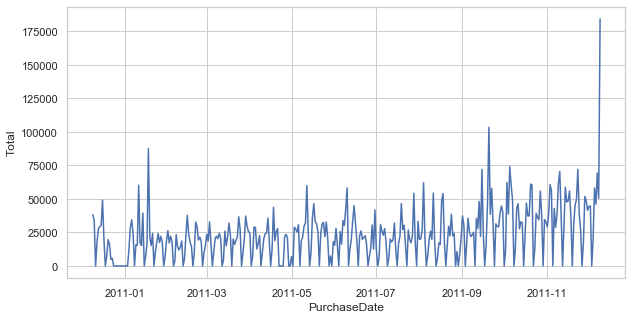

In [30]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=pur, x='PurchaseDate',y='Total')

Text(0.5, 1.0, '每天的購買金額')

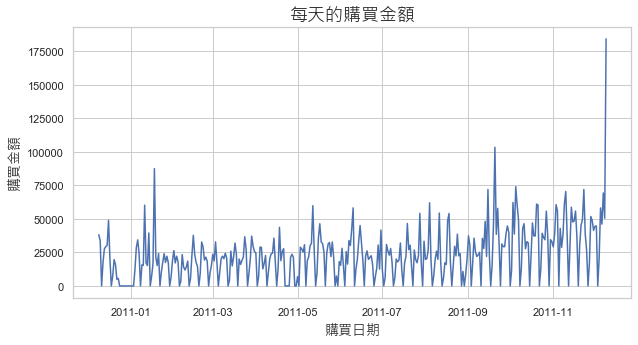

In [31]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=pur, x='PurchaseDate',y='Total')
# 加上圖形上的標題
ax.set_xlabel('購買日期', fontproperties=han_font)
ax.set_ylabel('購買金額', fontproperties=han_font)
ax.set_title('每天的購買金額', fontproperties=han_font, fontsize=18)

(array([734107., 734138., 734169., 734197., 734228., 734258., 734289.,
        734319., 734350., 734381., 734411., 734442., 734472.]),
 <a list of 13 Text xticklabel objects>)

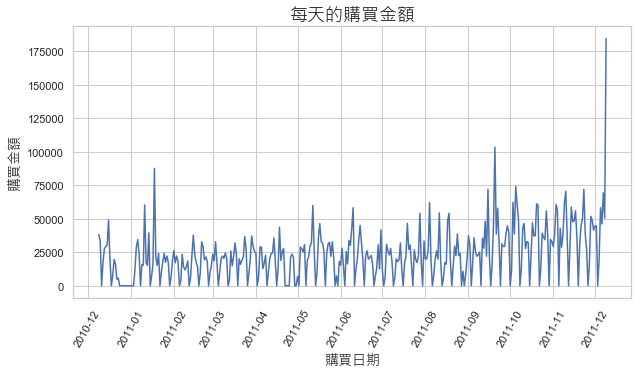

In [33]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data=pur, x='PurchaseDate',y='Total')
# 加上圖形上的標題
ax.set_xlabel('購買日期', fontproperties=han_font)
ax.set_ylabel('購買金額', fontproperties=han_font)
ax.set_title('每天的購買金額', fontproperties=han_font, fontsize=18)
# 改變x軸上的主要刻度為一個月
months = mdates.MonthLocator()  # every month
ax.xaxis.set_major_locator(months)
plt.xticks(rotation=60)

### 探討一天每個時段的購買金額總數

In [34]:
df_purchase.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PurchaseDate,PurchaseHour,Total
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09,8,47.4
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09,8,37.2
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09,8,15.3
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,8,31.8
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09,8,15.9


In [35]:
hour_purchase = df_purchase.groupby('PurchaseHour')[["Total"]].sum()\
.reset_index()

hour_purchase

,PurchaseHour,Total
0,6,4.250
1,7,30592.210
2,8,278196.960
3,9,820238.221
4,10,1234346.171
5,11,1079427.370
6,12,1335843.280
7,13,1136096.420
8,14,974736.821
9,15,931281.500


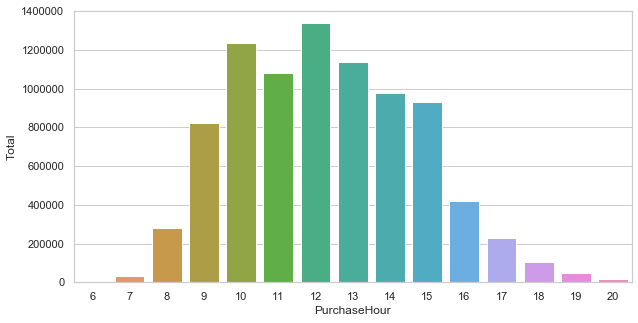

In [38]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=hour_purchase, x='PurchaseHour', y='Total')
# 加上圖形上的標題
ax.set_xlabel('購買時段', fontproperties=han_font)
ax.set_ylabel('購買金額', fontproperties=han_font)
ax.set_title('不同時段的購買金額', fontproperties=han_font, fontsize=18)

In [ ]:
每週各天的各時段購買金額

In [ ]:
df_purchase.assign(PurchaseHour=lambda x: x.InvoiceDate.dt.hour)\
.assign(Weekday=lambda x: x.InvoiceDate.dt.strftime("%a"))\
.assign(PurchaseTotal=lambda x: x.UnitPrice*x.Quantity)\
.groupby('Weekday')\
.groupby('PurchaseHour')\
.PurchaseTotal.sum()

In [ ]:
依據購買金額排序商品

In [ ]:
依據取消金額排序商品